<a href="https://colab.research.google.com/github/essiesalari/Image-Classification-CIFAR10_DL/blob/main/CIFAR10_Image_Classificatio__CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CIFAR10 Image Classification**

## Import Libraries and the Dataset

In [1]:
import numpy as np
import os
import time
import pickle
from tqdm import tnrange, tqdm_notebook
from IPython import display

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (12, 5)

import tensorflow as tf
import tensorflow.keras
from tensorflow import keras
from tensorflow.keras import models, layers, activations
from keras.models import Model
from PIL import Image, ImageFilter
from keras import regularizers

In [2]:
from tensorflow.keras.utils import get_file
origin_url = 'https://surfdrive.surf.nl/files/index.php/s/{key}/download'

# Dictionary mapping file names to download keys
files = {
    'cifar10-batch-1': '4Nee36XgbYjp3N6',
    'cifar10-batch-2': 'LVx85dLceKI5toF',
    'cifar10-batch-3': '4FoFmeKyXa5sYr0',
    'cifar10-batch-4': 'a4o2RatC0Fa3Exb',
    'cifar10-batch-5': 'eqBJRWdkRGk025k',
    'cifar10-test': 'nEf9Z4eg7iGmWGU'
}

# Doanload files to local drive
local_files = [{'name': n,'file': get_file(n, origin=origin_url.format(key=k))} for n,k in files.items()]

# Load all batches in memory
batches = {lf['name']: pickle.load(open(lf['file'], 'rb'), encoding='latin1') for lf in local_files}

# Convert data to floats and reshape to correct format (specifically for CIFAR10)
for batch in batches.values():
  batch['data'] = (batch['data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1) / 255.).astype('float32')

data_size_in = (32, 32, 3)
n_classes = 10

31035526/31035526 [==============================] - 10s 0us/step


In [3]:
print(batches.keys())

dict_keys(['cifar10-batch-1', 'cifar10-batch-2', 'cifar10-batch-3', 'cifar10-batch-4', 'cifar10-batch-5', 'cifar10-test'])


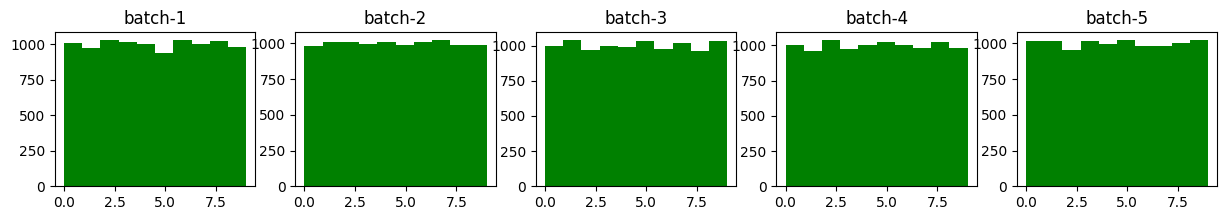

In [4]:
fig = plt.figure(figsize=(15, 2))
for i in range(1,6):
  plt.subplot(1, 5, i)
  plt.hist(batches[f'cifar10-batch-{i}']['labels'], color='green')
  plt.title(f'batch-{i}')

As it is clear from histograms, the distribution is balanced (not skewed).
The margins between classes, in each batch, look acceptable, so we would not face any problem related to imbalanced data.





## Training, Validation and Test Split Function

In [5]:
def load_data():

  # Training set
  train_x=np.zeros((40000, 32, 32, 3)).astype("float32")
  train_x[0:10000] = batches['cifar10-batch-1']['data']
  train_x[10000:20000] = batches['cifar10-batch-2']['data']
  train_x[20000:30000] = batches['cifar10-batch-3']['data']
  train_x[30000:40000] = batches['cifar10-batch-4']['data']

  train_y = np.zeros((40000))
  train_y[0:10000] = batches['cifar10-batch-1']['labels']
  train_y[10000:20000] = batches['cifar10-batch-2']['labels']
  train_y[20000:30000] = batches['cifar10-batch-3']['labels']
  train_y[30000:40000] = batches['cifar10-batch-4']['labels']

  # Validation set
  val_x = batches['cifar10-batch-5']['data']
  val_y = batches['cifar10-batch-5']['labels']

  # Test set
  test_x = batches['cifar10-test']['data']

  # Load labels
  label_to_names = {0: 'airplane', 1: 'automobile', 2: 'bird',
                    3: 'cat', 4: 'deer', 5: 'dog',
                    6: 'frog', 7: 'horse',8: 'ship',
                    9: 'truck'}

  print ("-----------------------------------------------------")
  print (label_to_names)
  print ("-----------------------------------------------------")
  print (f"> shape training set tensor: {train_x.shape}")
  print (f"> length training labels: {len(train_y)}")
  print ("-----------------------------------------------------")
  print (f"> shape validation set tensor: {val_x.shape}")
  print (f"> length training labels: {len(val_y)}")
  print ("-----------------------------------------------------")
  print (f"> shape test set tensor: {test_x.shape}")

  return train_x, train_y, val_x, val_y, test_x

## Build the ConvNet

In [6]:
def CNN(data_size_in, n_classes, drop_out_share):
  # Initializer
  initializer = tf.keras.initializers.HeNormal()
  # Input layer
  inputs = layers.Input(shape=data_size_in)

  # Convolutional, batch normalization, pooling and droput layers
  net_1 = layers.Conv2D(64, kernel_size=(5, 5), activation='relu', padding='same', kernel_initializer=initializer)(inputs)
  net_2 = layers.BatchNormalization()(net_1)
  net_3 = layers.Conv2D(64, kernel_size=(5, 5), activation='relu', kernel_initializer=initializer)(net_2)
  net_4 = layers.BatchNormalization()(net_3)
  net_5 = layers.MaxPool2D(pool_size=(2, 2))(net_4)
  net_6 = layers.Dropout(drop_out_share)(net_5)

  net_7 = layers.Conv2D(32, kernel_size=(5, 5), activation='relu', kernel_initializer=initializer)(net_6)
  net_8 = layers.BatchNormalization()(net_7)
  net_9 = layers.MaxPool2D(pool_size=(2, 2))(net_8)
  net_10 = layers.Dropout(drop_out_share)(net_9)

  net_11 = layers.Flatten()(net_8)

  net_12 = layers.Dense(256, activation='relu', kernel_initializer=initializer)(net_11)
  net_13 = layers.BatchNormalization()(net_12)
  net_14 = layers.Dropout(drop_out_share)(net_13)

  net_15 = layers.Dense(128, activation='relu', kernel_initializer=initializer)(net_14)
  net_16 = layers.BatchNormalization()(net_15)
  net_17 = layers.Dropout(drop_out_share)(net_16)

  # Output layer
  prediction = layers.Dense(n_classes, activation='softmax')(net_17)

  # Functional API
  model = Model(inputs=inputs, outputs=prediction)
  print(model.summary())

  return model

## CNN's Loss Function, Optimizer and Metric

In [13]:
from tensorflow.keras.optimizers import Adam

lf = 'CategoricalCrossentropy'
lr = 0.001
Adam = Adam(learning_rate=lr)
metric = ['acc']
drop_out_share = 0.25

network = CNN(data_size_in, n_classes, drop_out_share)
network.compile(loss=lf, optimizer=Adam, metrics=metric)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 64)        4864      
                                                                 
 batch_normalization_10 (Ba  (None, 32, 32, 64)        256       
 tchNormalization)                                               
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 64)        102464    
                                                                 
 batch_normalization_11 (Ba  (None, 28, 28, 64)        256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 14, 14, 64)        0   

## Lables One-hot Encoding

In [14]:
train_x, train_y, val_x, val_y, test_x = load_data()

train_y_one_hot = tf.keras.utils.to_categorical(train_y, num_classes=n_classes, dtype='float32')
val_y_one_hot = tf.keras.utils.to_categorical(val_y, num_classes=n_classes, dtype='float32')

print (np.sum(train_y_one_hot, axis=0))
print (np.sum(val_y_one_hot, axis=0))

-----------------------------------------------------
{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}
-----------------------------------------------------
> shape training set tensor: (40000, 32, 32, 3)
> length training labels: 40000
-----------------------------------------------------
> shape validation set tensor: (10000, 32, 32, 3)
> length training labels: 10000
-----------------------------------------------------
> shape test set tensor: (10000, 32, 32, 3)
[3986. 3986. 4048. 3984. 4003. 3975. 4020. 4023. 3997. 3978.]
[1014. 1014.  952. 1016.  997. 1025.  980.  977. 1003. 1022.]


## Validate the Network

In [15]:
scores = network.evaluate(val_x, val_y_one_hot, batch_size=None)
val_loss = scores[0]
val_acc = scores[1]
print(f'Inittial validation accuracy = {100. * val_acc:.2f}%')

313/313 [==============================] - 2s 4ms/step - loss: 2.5867 - acc: 0.0948
Inittial validation accuracy = 9.48%


## Train the Network

In [16]:
def train_network(network, x_training, y_training, x_validation, y_validation, n_epoch, batch_size, network_filepath):

  tra_losses = []
  tra_accs = []
  val_losses = []
  val_accs = []

  best_validation_accuracy=0

  for epoch in range(n_epoch):
    st = time.time()

    # Train the network
    results = network.fit(x_training, y_training, batch_size)

    training_loss = results.history['loss']
    training_accuracy = results.history['acc']
    tra_losses.append(training_loss)
    tra_accs.append(training_accuracy)

    # Evaluate performance on validation set
    scores = network.evaluate(x=x_validation, y=y_validation, batch_size=1)

    validation_loss = scores[0]
    validation_accuracy = scores[1]
    val_losses.append(validation_loss)
    val_accs.append(validation_accuracy)

    if validation_accuracy > best_validation_accuracy:
      best_validation_accuracy = validation_accuracy
      network.save(network_filepath)

    # Visualize learning curves
    fig = plt.figure(figsize=(10, 5))
    tra_loss_plt, = plt.plot(range(len(tra_losses)), tra_losses, 'b')
    tra_accs_plt, = plt.plot(range(len(tra_accs)), tra_accs, 'c')
    val_loss_plt, = plt.plot(range(len(val_losses)), val_losses, 'm')
    val_acc_plt, = plt.plot(range(len(val_accs)), val_accs, 'r')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend([tra_loss_plt, tra_accs_plt, val_loss_plt, val_acc_plt],
              ['training loss', 'training accuracy', 'validation loss', 'validation accuracy'],
              loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Best validation accuracy = {:.2f}%'.format(100. * best_validation_accuracy))
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(.2)

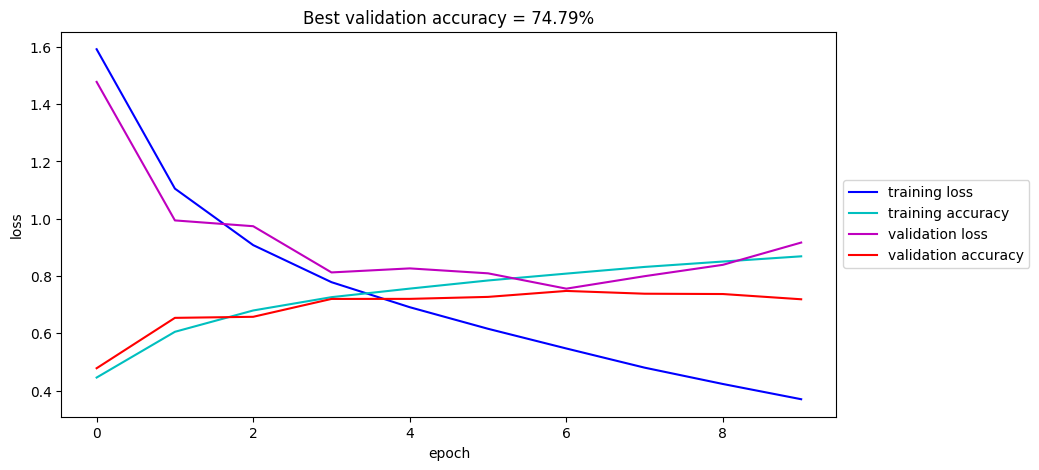

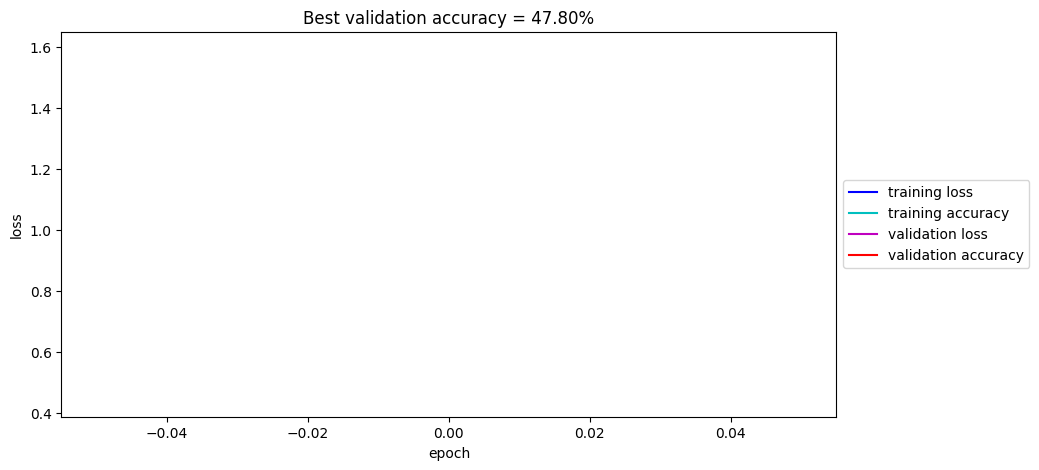

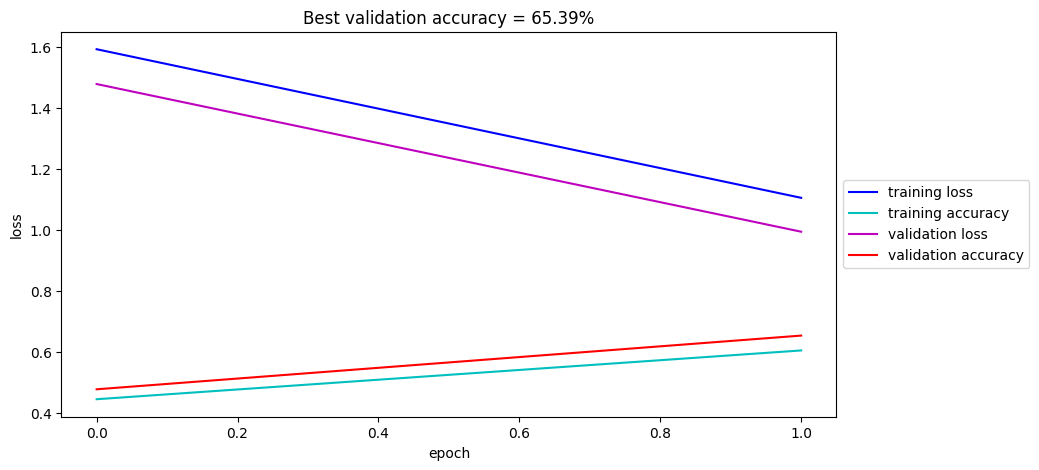

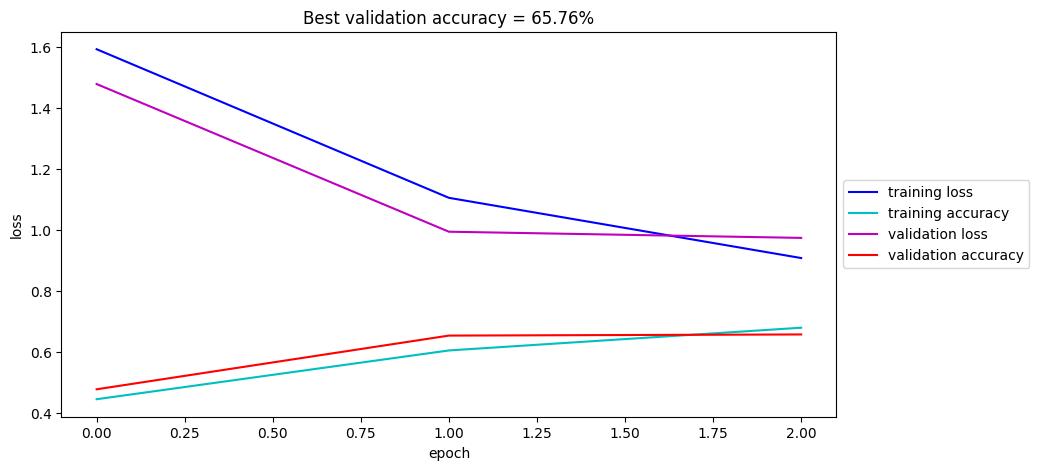

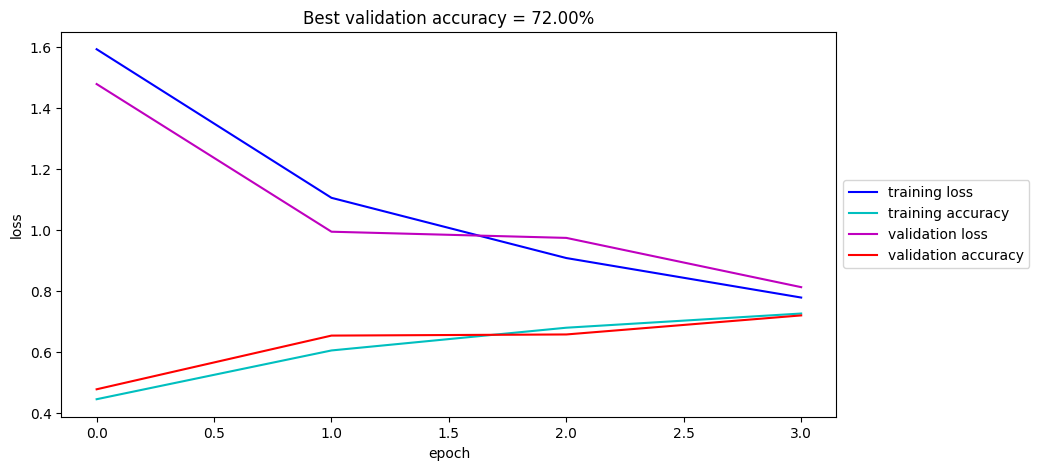

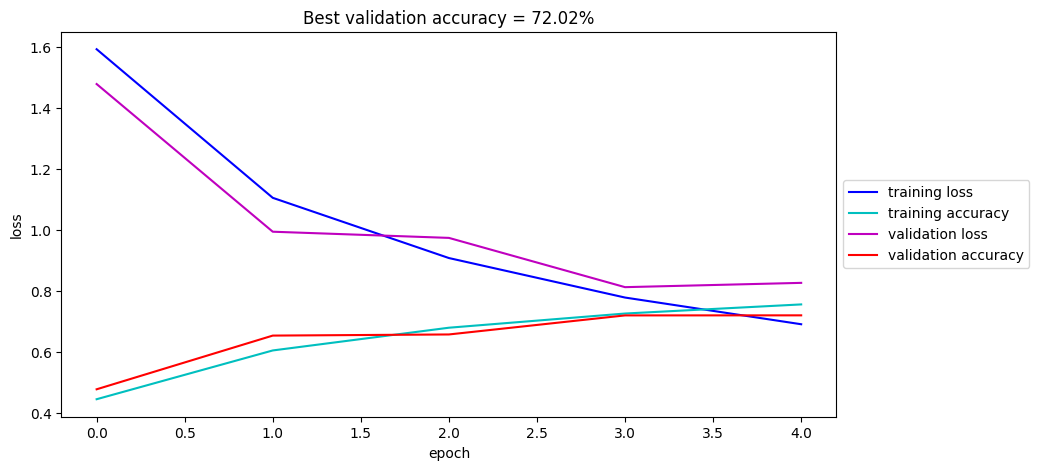

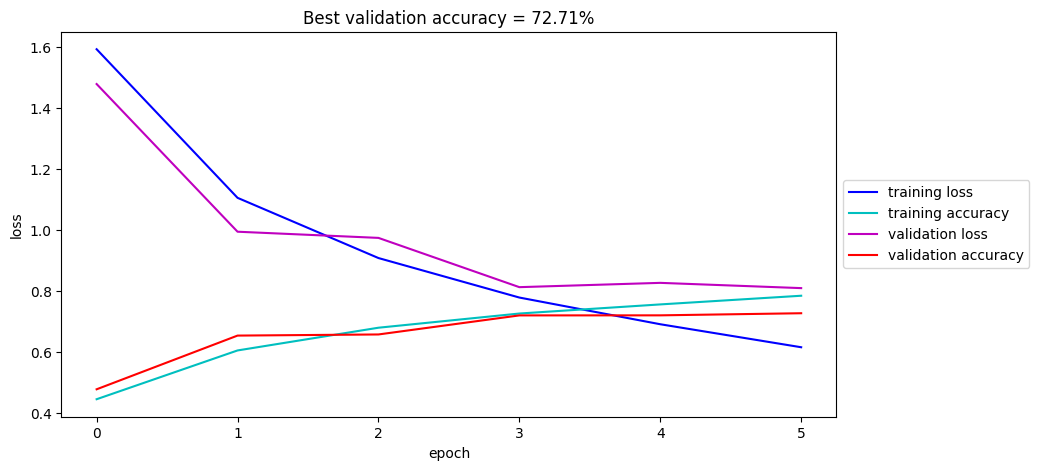

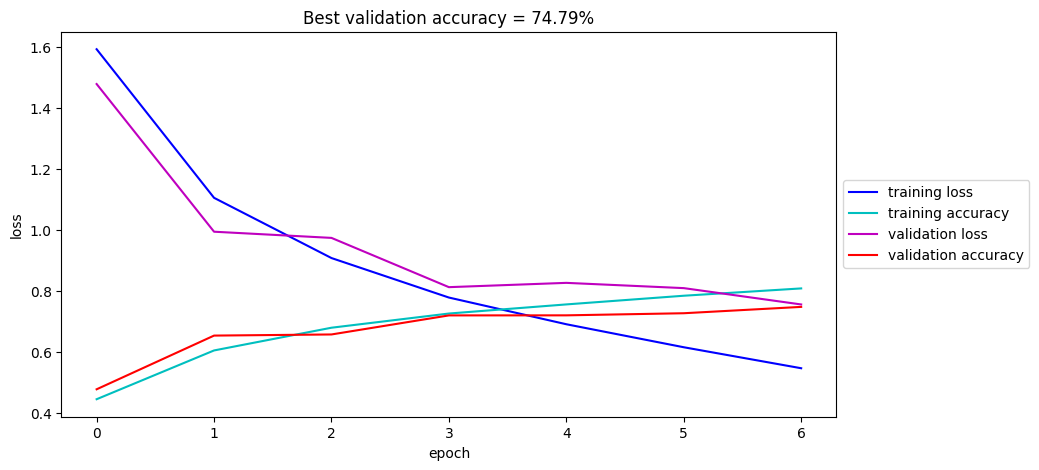

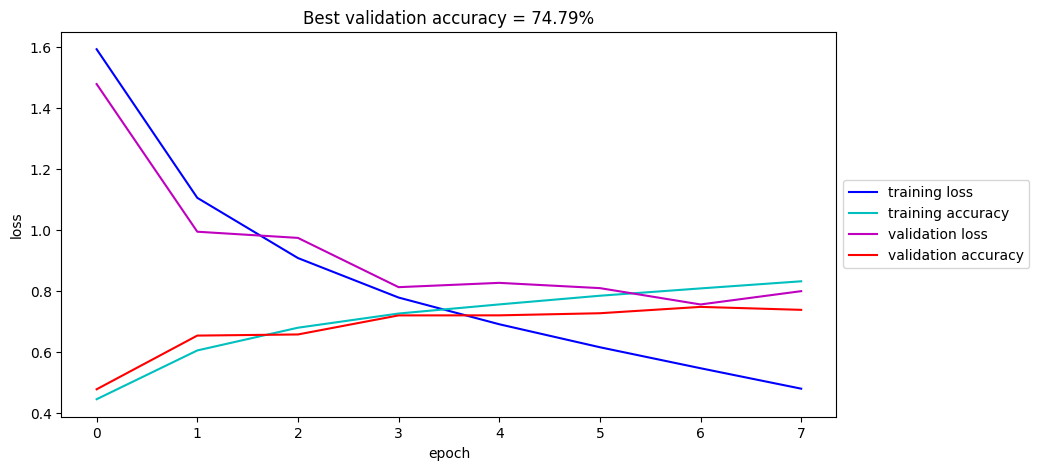

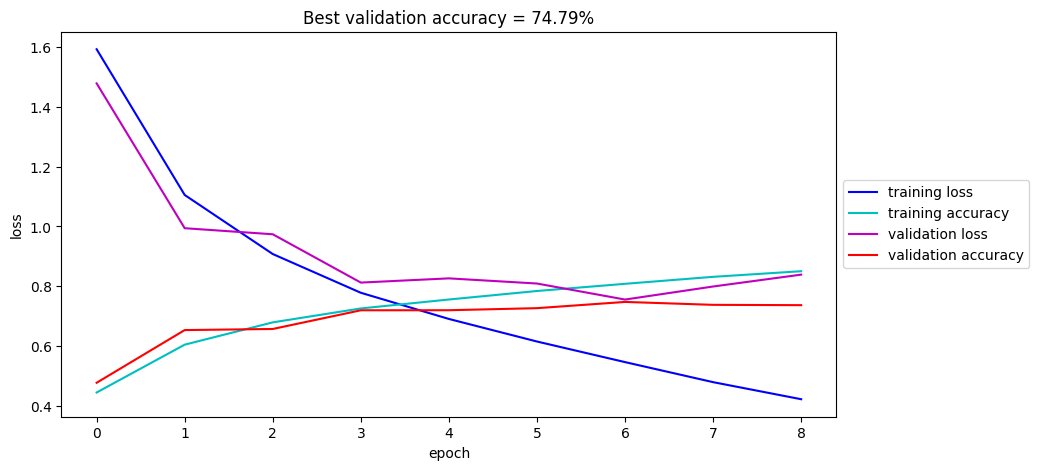

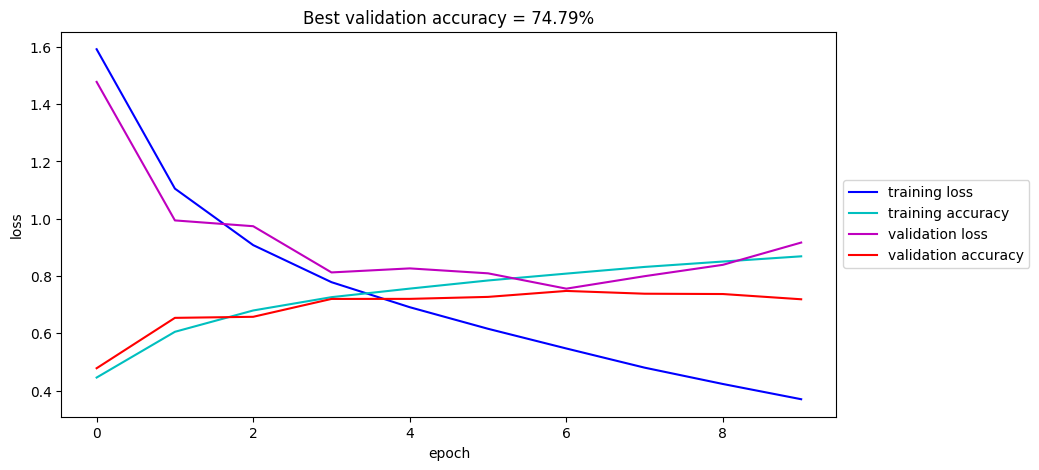

In [17]:
batch_size = 128
n_epoch = 10
file_dir = './'
network_filepath = os.path.join(file_dir, 'best_model_net_task_2.h5')

train_network(network, train_x, train_y_one_hot, val_x, val_y_one_hot, n_epoch, batch_size, network_filepath)

# **Appendix**

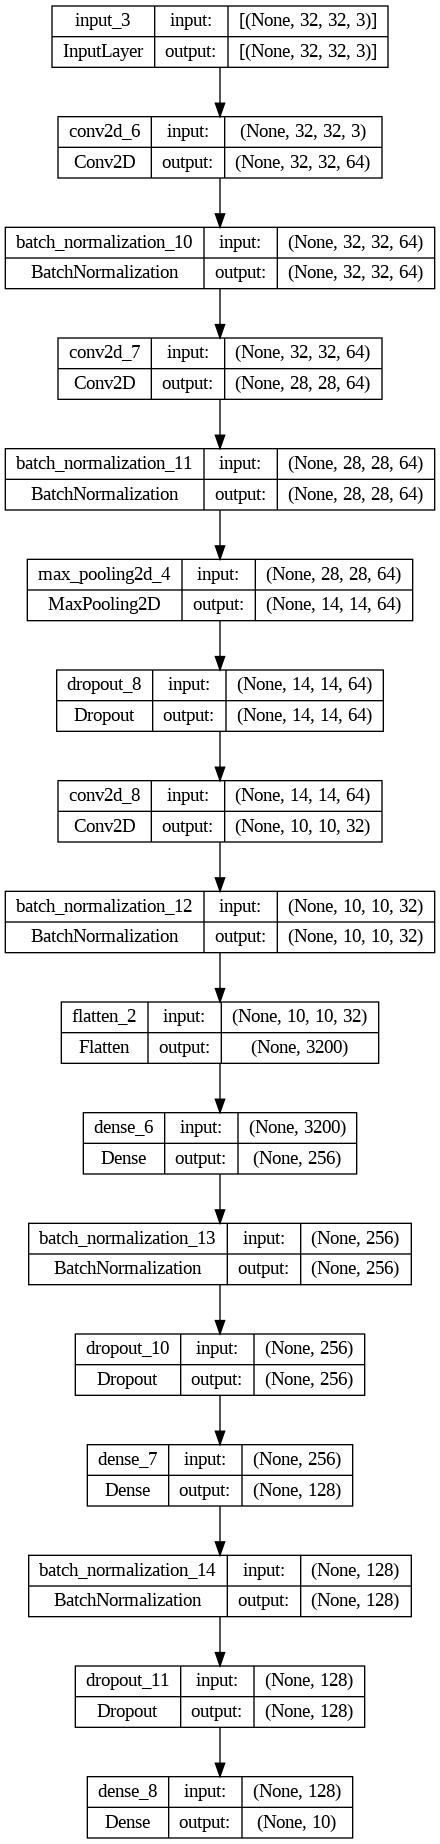

In [18]:
from tensorflow.keras.utils import plot_model

plot_model(network, to_file='model.png', show_shapes=True)